### Communication

In [9]:
# from ipaddress import IPv4Address 
# from pyairmore.request import AirmoreSession  
# from pyairmore.services.messaging import MessagingService  
# c = "192.168.1.4" 
# ip = IPv4Address(c) 
# s = AirmoreSession(ip)
# print("Running:", s.is_server_running)
# wa = s.request_authorization()
# print("Authorization:",wa)
# service = MessagingService(s) 

### Importing Libraries

In [10]:
import numpy
import numpy as npy 
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import firebase_admin
import cv2
import tensorflow as tf
import random
import json


import PIL
from IPython.display import display
from PIL import Image
from firebase_admin import db


cred_obj = firebase_admin.credentials.Certificate('./refToke.json')
default_app = firebase_admin.initialize_app(cred_obj, {
	'databaseURL':'https://tarp-project-ee72f-default-rtdb.firebaseio.com/'
	})
ref = db.reference("/coordinate")

### YOLO

In [11]:
def main1(n1,j): 
    y1 = 0
    n = n1 
    global ld # Global variable for showing last detected time
    
    # load the COCO class labels our YOLO model was trained on - *preset
    lpath = os.path.sep.join(['yolo-coco', "coco.names"])
    la = open(lpath).read().strip().split("\n")
    # derive the paths to the YOLO weights and model configuration - *preset
    weightsPath = os.path.sep.join(['yolo-coco', "yolov3.weights"])
    configPath = os.path.sep.join(['yolo-coco', "yolov3.cfg"])
    # load our YOLO object detector trained on COCO dataset (80 classes) - *preset
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    
    # load input to get its dimensions
    im = cv2.imread(n)
    (H, W) = im.shape[:2]

    # Colour for the labels
    npy.random.seed(42)
    colours = npy.random.randint(0, 255, size=(len(la), 3),dtype="uint8")

    # Naming layers - *preset
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward - *preset
    # pass of the YOLO object detector, giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(im, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    out = net.forward(ln)
    end = time.time()

    box1 = []
    classID1 = []
    confidence1 = []
    
    for o in out:
        for det in o:
            s1 = det[5:]
            classID = npy.argmax(s1)
            confidence = s1[classID]
            if confidence > 0.5:
                box = det[0:4] * npy.array([W, H, W, H])
                (cX, cY, w1, h1) = box.astype("int")
                x = int(cX - (w1 / 2))
                y = int(cY - (h1 / 2))
                box1.append([x, y, int(w1), int(h1)])
                confidence1.append(float(confidence))
                classID1.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding - *preset
    id1 = cv2.dnn.NMSBoxes(box1, confidence1, 0.5, 0.3)
    
    if len(id1) > 0:
        for i in id1.flatten():
            temp = []
            (x, y) = (box1[i][0], box1[i][1])
            (w, h) = (box1[i][2], box1[i][3])
            cl = [int(c) for c in colours[classID1[i]]]
            text = "{}".format(la[classID1[i]])
            if text == "person":
                area=w*h
                cv2.rectangle(im, (x-2, y-2), (x + w + 2, y + h + 2), cl, 2)
                cv2.putText(im, str(i)+", "+str(x)+" "+(str(y)), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, cl, 2)
                cv2.imwrite("test/detected/d{}.jpg".format(j),im)
                if area>100:
                    im_refined = cv2.imread("test/detected/d{}.jpg".format(j))
                    y1=1
    return y1

### Main module

In [12]:
def call(given):
    y0=0
    yes=0
    vid1 = "Demo/Geo/demo ({}).mp4".format(given)
    frames = 60
    # cv2.VideoCapture(0) - If you want webcam
    cap = cv2.VideoCapture(vid1)
    i,j,ld = 0,0,0

    while True:
        r, f = cap.read() 
        if r: 
            cv2.imshow('Test Video', f)   
            f = cv2.resize(f,(400,300))
            if i%frames == 0:
                try: 
                    j = j+1
                    s = "test/overall/ss{}.jpg".format(j)
                    cv2.imwrite(s,f)
                    y0 = main1(s,j)
                    if y0==1:
                        yes=1
                except:
                    pass
            i=i+1
            if cv2.waitKey(1) & 0xFF == ord('q'): 
            # Press Q to quit
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    return yes

### Plotting

In [13]:
def person(points1,p1,p2):
    
    origin = (40.684029, -73.977629)
    destination = (40.675965, -73.905801)
    coord = pd.read_csv("Dataset.csv")
    l1 = coord.drop(['Lane','Point'],axis=1).values.tolist()
    lane1 = l1[0:5]
    lane2 = l1[5:10]
    lane3 = l1[10:15]
    lane4 = l1[15:20]
    lane5 = l1[20:25]
    l2 = []
#     l2.append([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
    l2.append(lane1)
    l2.append(lane2)
    l2.append(lane3)
    l2.append(lane4)
    l2.append(lane5)
   
    initial1 = p1
    initial2 = p2
    if (p1,p2) in [(1,5),(5,5),(5,1),(1,1)]:
        l = [1,4,6]
        random.shuffle(l)
        for i in range(3):
            c = call(l[i])
            if c==1:
                if i==0:
                    if p1==1:
                        p1+=1
                    else:
                        p1-=1
                if i==1:
                    if p1==1:
                        p1+=1
                        if p2==1:
                            p2-=1
                        else:
                            p2+=1
                    else:
                        p1-=1
                        if p2==1:
                            p2-=1
                        else:
                            p2+=1
                if i==2:
                    if p2==5:
                        p2-=1
                    else:
                        p2+=1
                break
    else:
        l = [1,2,3,4,5,6,7,8]
        random.shuffle(l)
        for i in range(8):
            c = call(l[i])
            if c==1:
                if i==0:
                    p2=p2+1
                if i==1:
                    p1+=1
                    p2+=1
                if i==2:
                    p1+=1
                if i==3:
                    p1+=1
                    p2-=1
                if i==4:
                    p2-=1
                if i==5:
                    p1-=1
                    p2-=1
                if i==6:
                    p1-=1
                if i==7:
                    p2+=1
                    p1-=1
                break
    if (p1,p2) in points1:
        return person(points1,initial1,initial2)
    elif p1 not in range(1,6) or p2 not in range(1,6):
        return person(points1, initial1, initial2)
    else:
        points1.append((p1,p2))
        print(points1)
        message = "Suspect found at "+str(p1)+","+str(p2)
        person.len = person.len + 1
        print("idx",p1," ",p2)
        print(str(l2[p1-1][p2-1][0]) + ',' + str(l2[p1-1][p2-1][1]))
        print("idx",p1,p2)
        fdict[person.len] = str(l2[p1-1][p2-1][0])+ "," + str(l2[p1-1][p2-1][1])
        
        ref.set(fdict)
        # service.send_message("9500356597", message) 
        print(message)
        return points1

### Display

In [14]:
import random

[(1, 5), (2, 5)]
idx 2   5
40.676789,-73.921611
idx 2 5
Suspect found at 2,5


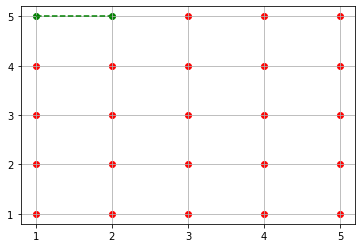

[(1, 5), (2, 5), (2, 4)]
idx 2   4
40.677265000000006,-73.930437
idx 2 4
Suspect found at 2,4


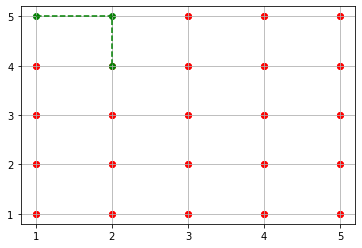

[(1, 5), (2, 5), (2, 4), (3, 5)]
idx 3   5
40.668217,-73.922777
idx 3 5
Suspect found at 3,5


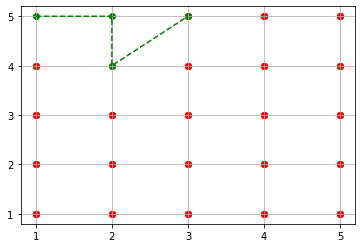

[(1, 5), (2, 5), (2, 4), (3, 5), (3, 4)]
idx 3   4
40.668545,-73.931327
idx 3 4
Suspect found at 3,4


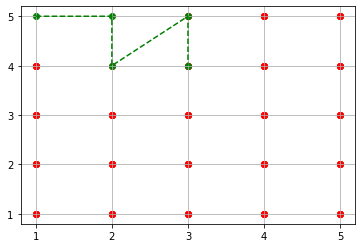

[(1, 5), (2, 5), (2, 4), (3, 5), (3, 4), (4, 3)]
idx 4   3
40.664119,-73.945293
idx 4 3
Suspect found at 4,3


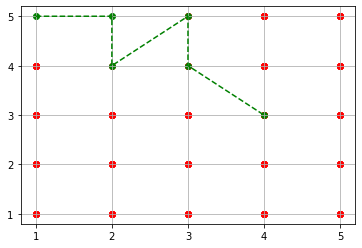

In [15]:
points = []
points1 = [(1,5)]

fdict = {}
person.len = 0
# idx = 0
fdict[0] = "40.684029" + "," + "73.977629"
# for i in range(6):
#     fdict[str(i)] = None
# person.len = 0;
for i in range(5):
    points1 = person(points1,points1[-1][0],points1[-1][1])
    for k in range(1,6):
            for l in range(1,6):
                if (k,l) not in points1:
                    points.append((k,l))
    x = list(map(lambda x: x[0], points))
    y = list(map(lambda x: x[1], points))

    x1 = list(map(lambda x1: x1[0], points1))
    y1 = list(map(lambda x1: x1[1], points1))

    plt.xticks(npy.arange(1, 6, 1))
    plt.yticks(npy.arange(1, 6, 1))
    plt.scatter(x,y,c="r")
    plt.scatter(x1,y1,c="g")
    plt.grid(True)
    plt.plot(x1,y1,'g--');
    plt.show()